*** The Lending Club: Loan default prediction ***

*MLND Capstone Project Notebook*

**II. Analysis **

*Data Exploration*

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
from sklearn import tree
%matplotlib inline

In [2]:
def maybe_load_loan_data(threshold=1, path='/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/', force='n'):
    def load_data():
        data = pd.read_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/loan.csv')#, na_values=['NA'])
        t = len(data) / threshold
        data = data.dropna(thresh=t, axis=1) # Drop any column with more than 50% missing values
        return data

    #df = pd.read_csv('loan.csv', na_values=['NA'], nrows=10000)
    try:
        if df.empty or force=='y':
            data = load_data()
        else:
            return df
    except:
        data = load_data()

    return data

df = maybe_load_loan_data(2)

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def show_stats(df):
     # How many null descriptions
     print ("How many null descriptions? {}".format(len(df[df['desc'].isnull()])))

     # Average length of non null descriptions
     print ("Average length of Description Text {}".format(df['desc'].dropna().str.len().mean()))
    
     print ("Number of records {}".format(len(df)))
     print ("Dataset Shape {}".format(df.shape))

     sns.distplot(df['desc'].dropna().str.len())

In [37]:
# Understand data correlations
numeric_features = df.select_dtypes(include=[np.number])
#numeric_features.describe()

categoricals = df.select_dtypes(exclude=[np.number])
#categoricals.describe()

corr = numeric_features.corr()

print (corr['loan_amnt'].sort_values(ascending=False)[:10], '\n')
print (corr['loan_amnt'].sort_values(ascending=False)[-10:])

''' move this to model evaluation section
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)'''

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


loan_amnt          1.000000
funded_amnt        0.999263
funded_amnt_inv    0.997115
installment        0.944977
out_prncp_inv      0.646898
out_prncp          0.646897
total_rec_int      0.533916
total_pymnt_inv    0.475655
total_pymnt        0.474626
total_rec_prncp    0.390473
Name: loan_amnt, dtype: float64 

collection_recovery_fee       0.052205
total_rec_late_fee            0.031395
dti                           0.020675
acc_now_delinq                0.003947
delinq_2yrs                  -0.000159
tot_coll_amt                 -0.004275
collections_12_mths_ex_med   -0.016650
inq_last_6mths               -0.034168
pub_rec                      -0.081177
policy_code                        NaN
Name: loan_amnt, dtype: float64


' move this to model evaluation section\nfrom sklearn.metrics import confusion_matrix\n\nconfmat = confusion_matrix(y_true=y_test, y_pred=y_pred)\nprint(confmat)'

In [5]:
def show_dictionary(path='/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/LCDataDictionary.xlsx'):
    data_dictionary = pd.read_excel(path)

    print(data_dictionary.shape[0])
    print(data_dictionary.columns.tolist())

    data_dictionary.rename(columns={'LoanStatNew': 'name',
                                    'Description': 'description'})
    return data_dictionary

dict = show_dictionary()
dict.head()

80
['LoanStatNew', 'Description']


,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee


*Exploratory Visualization*

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_



Running Data Visualisations

In [188]:
df = maybe_load_loan_data(threshold=2, force='y')

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
sns.pairplot(df[['loan_amnt', 'annual_inc', 'emp_length', \
                  'dti', 'grade', 'loan_status']].dropna(), hue='grade')
#plt.set_xticklabels(rotation=30)

In [ ]:
g = sns.factorplot(x="grade", y="loan_amnt", hue="isDefault", order=["A","B","C","D","E","F","G"], data=df, size=6, \
                    kind="violin", split=True, cut=1, aspect=1)

g2 = sns.factorplot(x="purpose", y="loan_amnt", hue="isDefault", data=df, size=6, \
                    kind="violin", split=True, cut=1, aspect=1)
g2.set_xticklabels(rotation=90)

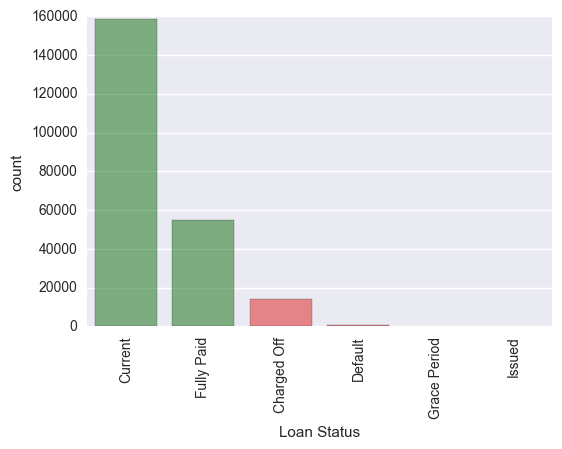

In [210]:
#mapping = {'loan_status':{'Fully Paid':0, 'Charged Off': 1}}
plt.xticks(rotation=90)
proc_issue_d()
df = df[df['issue_year'].isin(['2014'])]
#filtered_loans = df[df['issue_year'].isin(['2014'])]

#df_status = df.loc[df['loan_status'].isin(['Current','Charged Off','Default','Fully Paid','In Grace Period','Late (16-30 days)','Late (31-120 days)'])]
colours = ['green','green','red','red','red','grey']

sns.countplot(df['loan_status'], \
              order=['Current','Fully Paid', 'Charged Off', 'Default', 'Grace Period', 'Issued'], \
              palette=colours, alpha=0.5)
plt.xlabel('Loan Status')

plot partial dependence

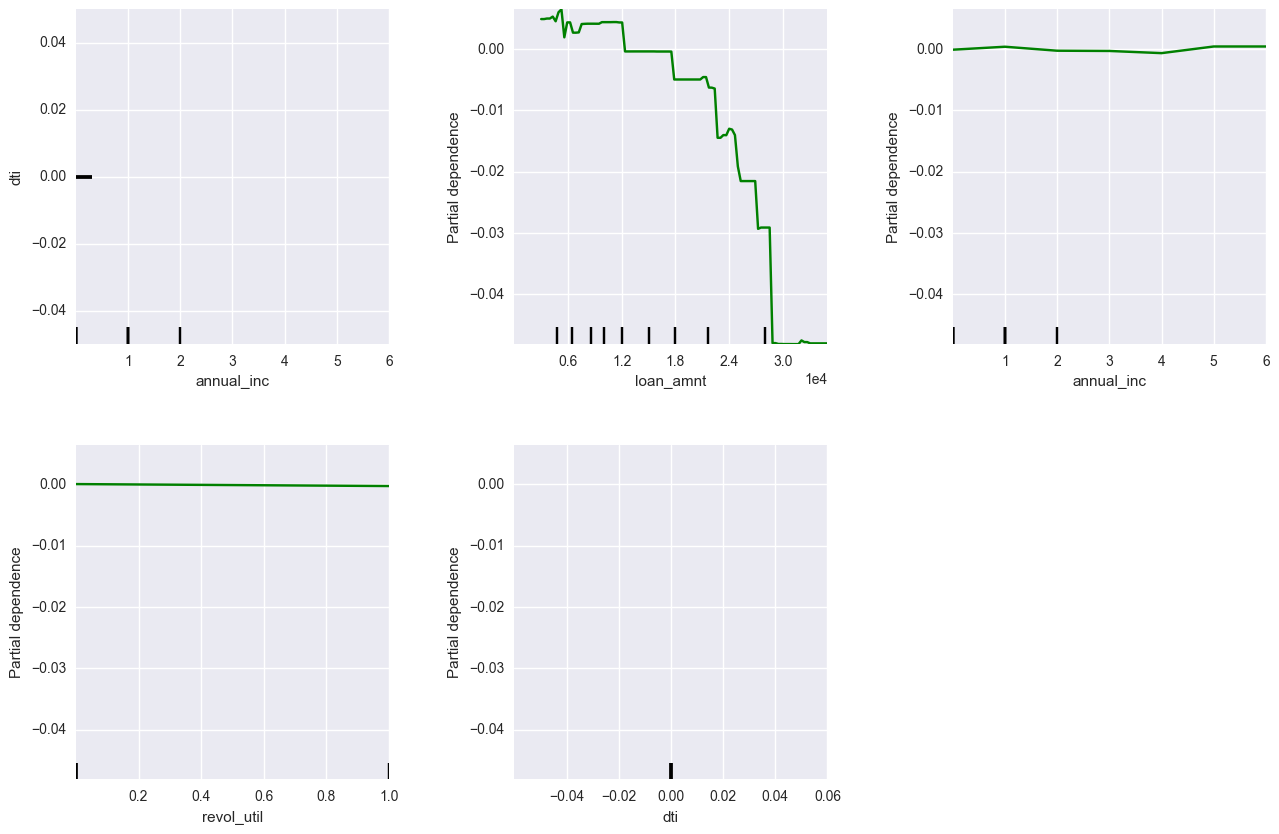

In [97]:
from sklearn import ensemble
from sklearn.ensemble.partial_dependence import plot_partial_dependence

est = ensemble.GradientBoostingRegressor(n_estimators=2000).fit(X_train, y_train)
comp_features = [('annual_inc','dti'),'loan_amnt','annual_inc', 'revol_util', 'dti']

fig, axs = plot_partial_dependence(est, X_train, comp_features,
                                   feature_names=list(df.columns),
                                   figsize=(14, 14), n_jobs=4)

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


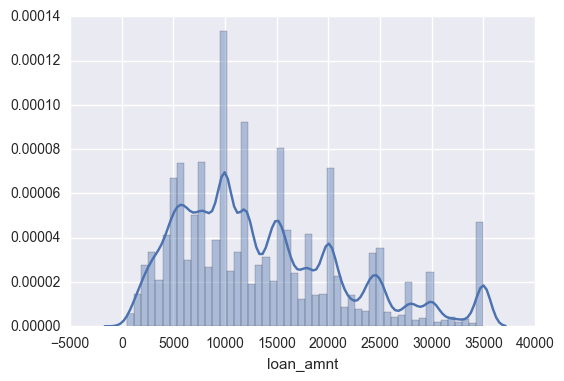

In [95]:
sns.distplot(df['loan_amnt'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

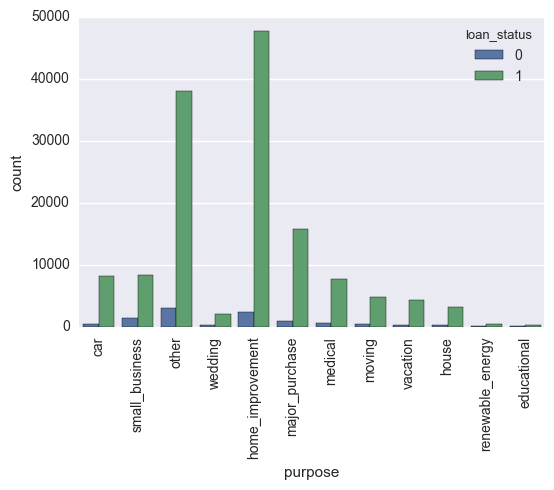

In [294]:
df_sub = df[df.purpose.isin(['debt_consolidation', 'credit_card']) == False]
sns.countplot(x="purpose", hue="loan_status", data=df_sub)
plt.xticks(rotation=90)

In [ ]:
df[df.purpose.isin(['debt_consolidation', 'credit_card']) == False].groupby(by=['loan_status','purpose']).count()['id']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bbbd8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12b679ac8>]], dtype=object)

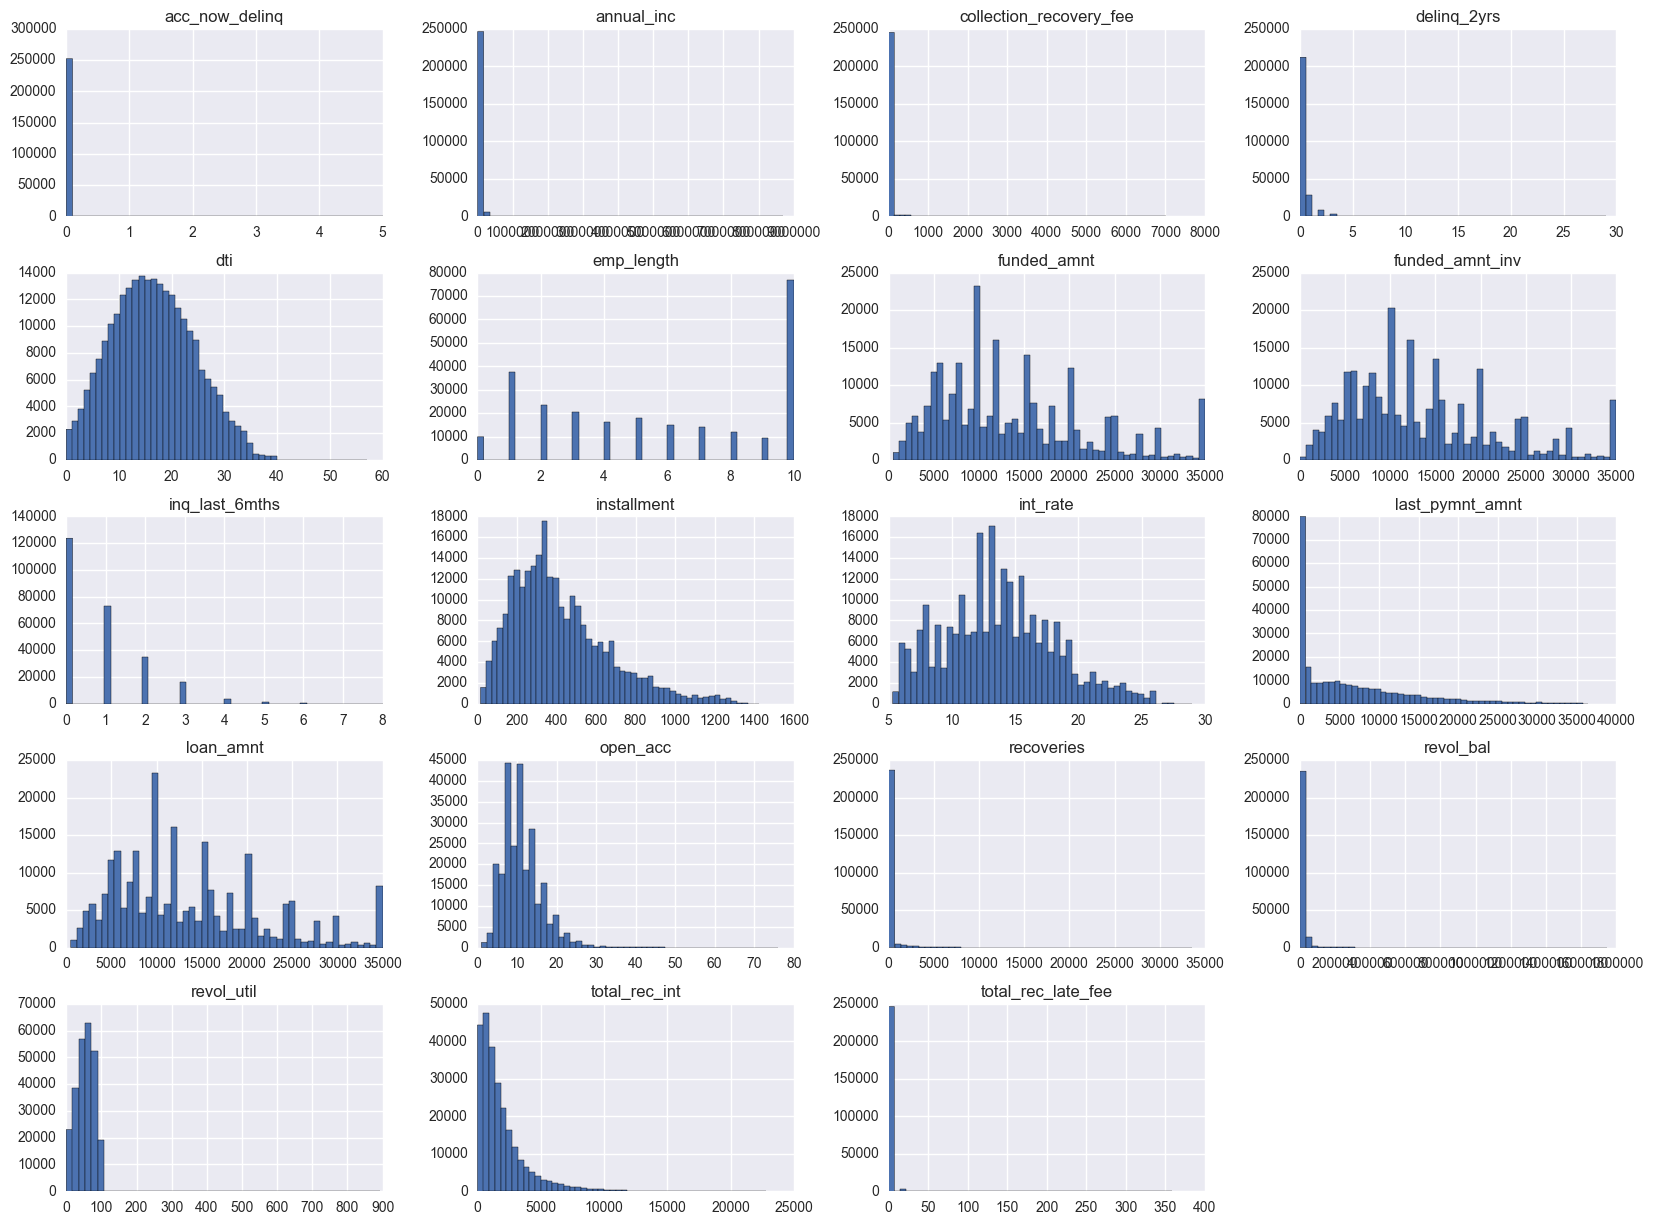

In [112]:
#df.hist(bins=50, figsize=(20,15))
df.select_dtypes(include=[np.number]).hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b638160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10aa95c18>]], dtype=object)

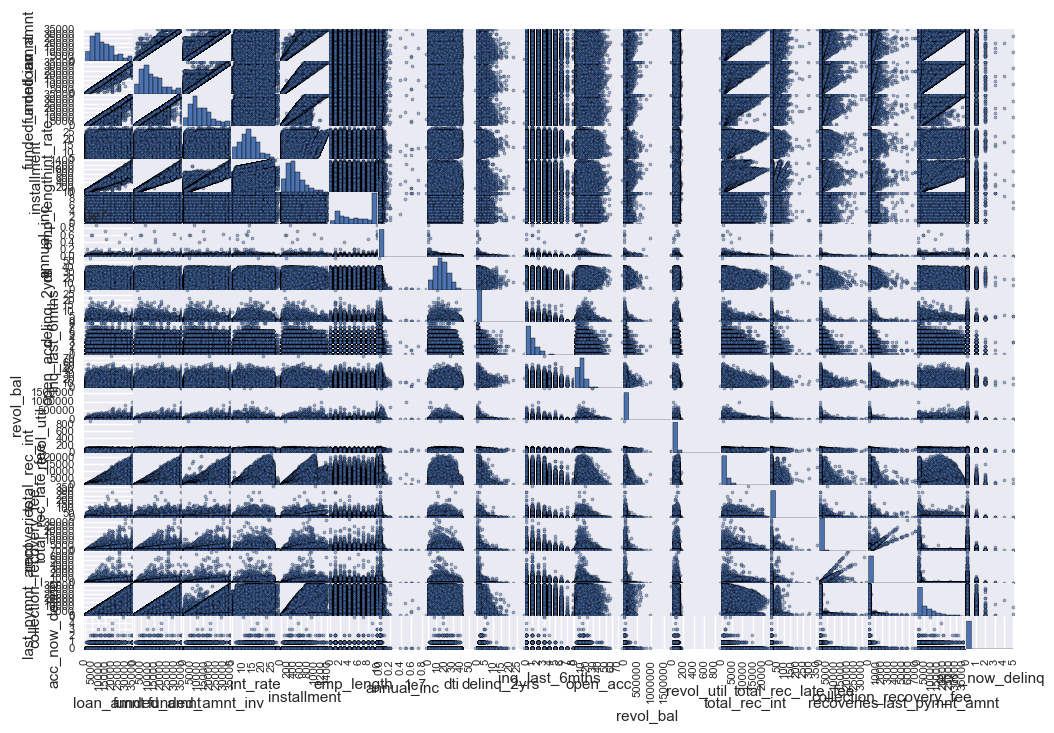

In [113]:
from pandas.tools.plotting import scatter_matrix

attributes = ['annual_inc','loan_amnt', 'revol_util', 'dti','open_acc','revol_bal','revol_util','total_rec_int' ]
#              'recoveries','acc_now_delinq','delinq_2yrs','emp_length','int_rate','funded_amnt'

scatter_matrix(df.select_dtypes(include=[np.number]), figsize=(12,8))

In [107]:
df[attributes].head()

,annual_inc,loan_amnt,revol_util,dti,open_acc,revol_bal,revol_util,total_rec_int
0,24000.000,5000.000,83.700,27.650,3.000,13648.000,83.700,861.070
1,30000.000,2500.000,9.400,1.000,3.000,1687.000,9.400,435.170
2,12252.000,2400.000,98.500,8.720,2.000,2956.000,98.500,603.650
3,49200.000,10000.000,21.000,20.000,10.000,5598.000,21.000,2209.330
5,36000.000,5000.000,28.300,11.200,9.000,7963.000,28.300,631.380


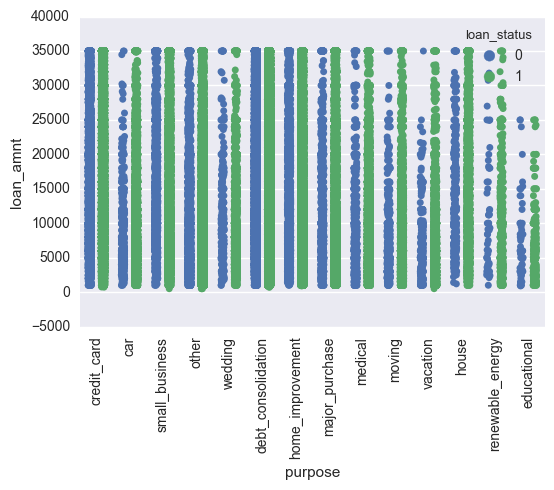

In [293]:
plt.xticks(rotation=90)
sns.stripplot(data=df[['loan_status','loan_amnt', 'purpose']], x='purpose', y='loan_amnt', \
              jitter=True, hue='loan_status', split=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

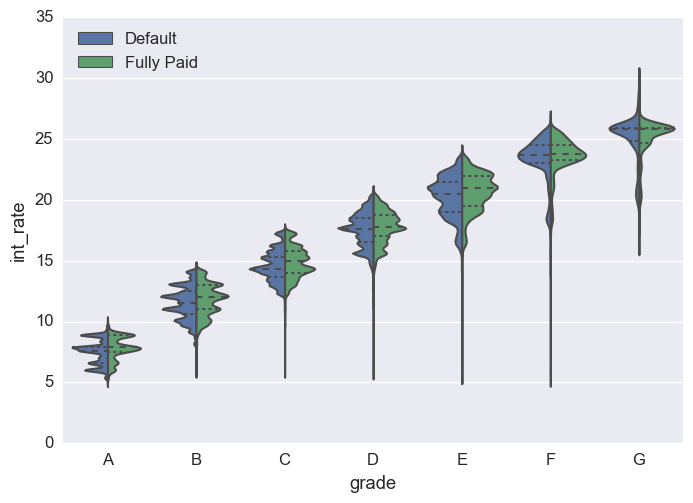

In [22]:
mapping_dict = {'loan_status':{1:'Fully Paid', 0:'Default'}}
df = df.replace(mapping_dict)

p2 = sns.violinplot(data=df[['loan_status', 'int_rate', 'grade']], hue='loan_status', x='grade', \
               order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], y='int_rate', split=True, inner='quartile', cut=4)

plt.legend(loc='upper left')
plt.xticks(rotation=0)

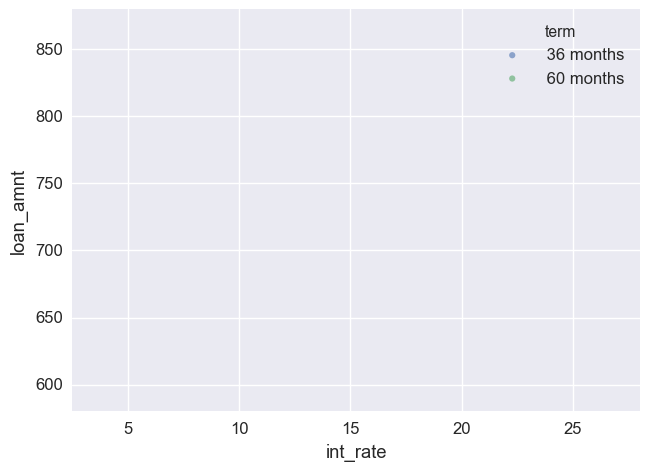

In [8]:
plot_df = df.query('loan_amnt > 10 & int_rate <28')[:3000]

sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5}) 

g = sns.lmplot("int_rate", "loan_amnt", x_jitter= .7,  y_jitter= .1,
           data=plot_df, hue='term',lowess=True, size=5,aspect=1.4, legend_out=False,
           scatter_kws={ 's':20, 'alpha':.6})

g.set(xlim=(2.5, 28),ylim=(580, 880),alpha = .5)

# Data Preprocessing

** Cleaning abnomalies **

Converting data format and type for some features:

Employment Length

In [4]:
def print_data_shape(df):
    print ("No rows: {}".format(df.shape[0]))
    print ("No cols: {}".format(df.shape[1]))
    print (df.head(1).values)
    print ("Columns: " + df.columns)

In [5]:
def proc_emp_length():
    df.replace('n/a', np.nan, inplace=True)
    df.emp_length.fillna(value=0, inplace=True)
    df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
    df['emp_length'] = df['emp_length'].astype(int)
    #df.emp_length.head()

interest rate

Revolving Utility

In [8]:
df.revol_bal.head()
#df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

0    13648.0
1     1687.0
2     2956.0
3     5598.0
4    27783.0
Name: revol_bal, dtype: float64

Emloyment Title

In [9]:
print (df.emp_title.value_counts().head())
print (df.emp_title.value_counts().tail())
df.emp_title.unique().shape

Teacher             13469
Manager             11240
Registered Nurse     5525
Owner                5376
RN                   5355
Name: emp_title, dtype: int64
Kenston Local Schools                  1
M.d. Anderson Cancer Center            1
Finance and Administrative Manager     1
Discovery Communications               1
South Puget Sound Community College    1
Name: emp_title, dtype: int64


(299273,)

Verified Income

In [ ]:
df.verification_status.value_counts()

Loan Description

In [6]:
def proc_desc_len():
    df['desc_lenght'] = df['desc'].fillna(0).str.len()

#df.desc_lenght

Issue Date

In [7]:
def proc_issue_d():
    df['issue_month'], df['issue_year'] = zip(*df.issue_d.str.split('-'))
    df.drop(['issue_d'], 1, inplace=True)

Zip Code

In [8]:
def proc_zip_code():
    df['zip_code'] = df['zip_code'].str.rstrip('x')

Purpose

In [29]:
print (df.purpose.value_counts())
print ('')
print (df.title.value_counts().head())

debt_consolidation    148286
credit_card            50062
home_improvement       14908
other                  14242
major_purchase          6248
small_business          4741
car                     3640
medical                 2843
moving                  2025
wedding                 1953
house                   1652
vacation                1583
educational              322
renewable_energy         267
Name: purpose, dtype: int64



Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'revol_util', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'application_type', 'acc_now_delinq', 'issue_month',
       'issue_year'],
      dtype='object')

In [ ]:
#df = maybe_load_loan_data(force='y', threshold=2)
df.plot(kind='barh', x='purpose', y='int_rate')

Drop attributes populated post loan completion

In [9]:
print_data_shape(df)

No rows: 887379
No cols: 53
[[1077501 1296599 5000.0 5000.0 4975.0 ' 36 months' 10.65 162.87 'B' 'B2'
  nan '10+ years' 'RENT' 24000.0 'Verified' 'Dec-2011' 'Fully Paid' 'n'
  'https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501'
  'credit_card' 'Computer' '860xx' 'AZ' 27.65 0.0 'Jan-1985' 1.0 3.0 0.0
  13648.0 83.7 9.0 'f' 0.0 0.0 5861.07141425 5831.78 5000.0 861.07 0.0 0.0
  0.0 'Jan-2015' 171.62 nan 'Jan-2016' 0.0 1.0 'INDIVIDUAL' 0.0 nan nan nan]]
Index(['Columns: id', 'Columns: member_id', 'Columns: loan_amnt',
       'Columns: funded_amnt', 'Columns: funded_amnt_inv', 'Columns: term',
       'Columns: int_rate', 'Columns: installment', 'Columns: grade',
       'Columns: sub_grade', 'Columns: emp_title', 'Columns: emp_length',
       'Columns: home_ownership', 'Columns: annual_inc',
       'Columns: verification_status', 'Columns: issue_d',
       'Columns: loan_status', 'Columns: pymnt_plan', 'Columns: url',
       'Columns: purpose', 'Columns: title', 'Columns: 

In [10]:
def drop_attrs(df, inc_ids=True):
    # Drop post loan attributes
    try:
        df.drop(['out_prncp','out_prncp_inv','total_pymnt',
                 'total_pymnt_inv', 'total_rec_prncp'], 1 , inplace=True)
        # Drop surrogate identifiers
        if inc_ids:
            df.drop(['id','member_id'], 1, inplace=True)
        # Dropping last few cols with too many nulls
        df.drop(['next_pymnt_d','total_rev_hi_lim','tot_coll_amt','tot_cur_bal','emp_title','last_pymnt_d', \
             'title','collections_12_mths_ex_med','last_credit_pull_d', 'total_acc', 'pub_rec', \
             'policy_code','pymnt_plan','earliest_cr_line'], 1, inplace=True)
        # drop text columns
        df.drop(['url'], 1, inplace=True)
        # drop last few records with nulls
        #df = df.dropna()
    except:
        print("Could not drop columns")

Look at correlation and eliminate highly correlated attributes

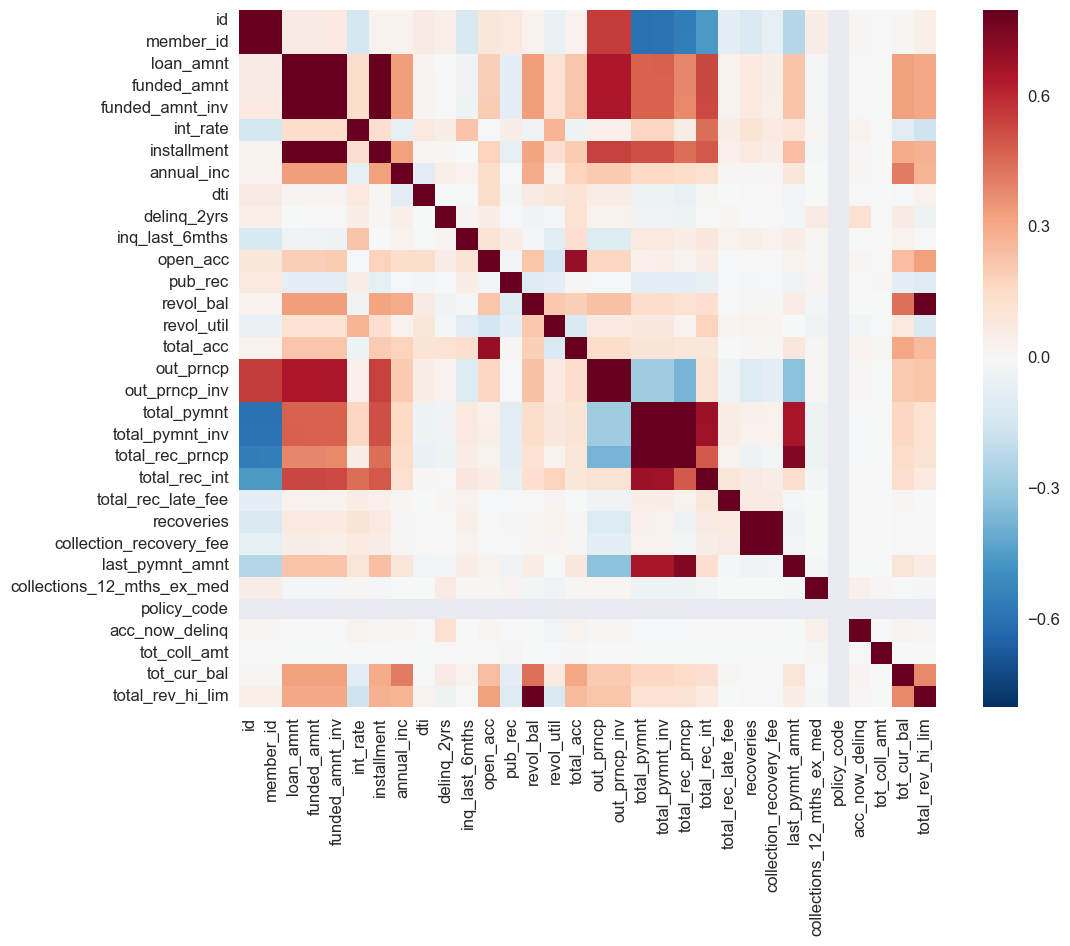

In [17]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

plt.subplots(figsize=(12, 9))
cor = df.corr()
# Draw the heatmap using seaborn
sns.heatmap(cor, vmax=.8, square=True)

Create Binary Classifier

In [11]:
def proc_loan_status(df):
    #mapping_dict = {'loan_status':{'Fully Paid':0, 'Charged Off': 1, 'Default': 1, 'Current': 0}}
    mapping_dict = {'loan_status':{'Fully Paid':0, 'Charged Off': 1}}
    df = df.replace(mapping_dict)
    df = df[(df['loan_status'] == 1) | (df['loan_status'] == 0)]
    return df

Handle Missing values

Policy Code, Public Record, Payment Plan

In [ ]:
df.policy_code.value_counts()
df.pub_rec.value_counts()
df.pymnt_plan.value_counts()

In [12]:
def show_nulls(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)[:25])
    nulls.columns = ['Null Count']   
    nulls.index.name = 'Feature'
    return nulls

Show dataset

In [ ]:
df.ix[:5,:10]

In [ ]:
df.ix[:5,11:20]

In [ ]:
df.ix[:5,31:40]

In [ ]:
df.ix[:5,51:60]

Prepare Data: One hot encode, Scaling, normalise

In [23]:
df = maybe_load_loan_data(threshold=2, force='y')

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

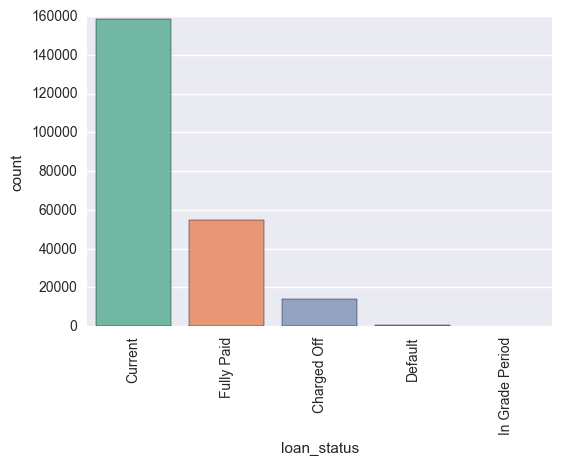

In [36]:
#len(df[df['issue_year'] == '2012'])
#proc_issue_d()

filtered_loans = df[df['issue_year'].isin(['2014'])]

sns.countplot(data=filtered_loans, x='loan_status', \
              order=['Current', 'Fully Paid','Charged Off', 'Default', 'In Grade Period'], palette='Set2')

plt.xticks(rotation=90)

In [40]:
def run_preproc(df):
    print ("processing emp_length")
    proc_emp_length()
    print ("processing description lenght")
    #proc_desc_len()
    print ("processing issue_d")
    proc_issue_d()
    print ("processing zip_code")
    proc_zip_code()

    print ("dropping cols")
    df.drop(['out_prncp','out_prncp_inv','total_pymnt',
             'total_pymnt_inv', 'total_rec_prncp'], 1 , inplace=True)
    # Drop surrogate identifiers
    df.drop(['id','member_id'], 1, inplace=True)
    # Dropping last few cols with too many nulls
    df.drop(['next_pymnt_d','total_rev_hi_lim','tot_coll_amt','tot_cur_bal','emp_title','last_pymnt_d', \
             'title','collections_12_mths_ex_med','last_credit_pull_d', 'total_acc', 'pub_rec', 'initial_list_status', \
             'policy_code','pymnt_plan','earliest_cr_line'], 1, inplace=True)
    # drop text columns
    df.drop(['url'], 1, inplace=True)
    # drop last few records with nulls
    df = df.dropna()

    print ("processing loan_status")
    df = proc_loan_status(df)
    print ("pre-processing complete")
    return df

df = maybe_load_loan_data(threshold=2, force='y')

df = run_preproc(df)
#show_nulls(df)

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


processing emp_length
processing description lenght
processing issue_d
processing zip_code
dropping cols
processing loan_status
pre-processing complete


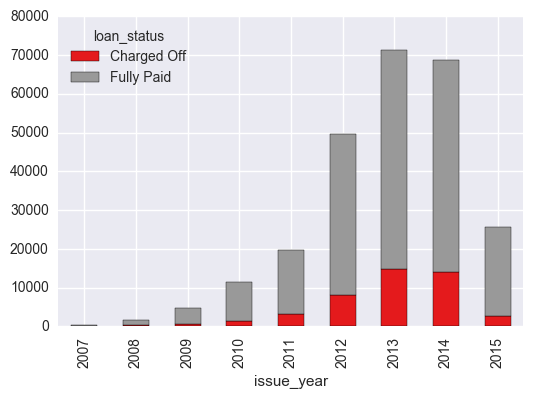

In [41]:
# data viz for
pd.set_option('display.float_format', lambda x: '%.3f' % x)
grp = df.groupby(by=['issue_year','loan_status']).count()['loan_amnt'] #.plot(kind='bar', stacked=True)

# re-map loan status to categorical feature
mapping_dict = {'loan_status':{0:'Fully Paid', 1: 'Charged Off'}}
df2 = df.replace(mapping_dict)

#df2 = df2[df2['purpose']=='debt_consolidation']

# Visualise Loan Default Percentage / ratio per year
grp_df = df2.groupby(['issue_year','loan_status']).count().unstack()
#tempdf['percent']=tempdf[0]/tempdf['total']*100
grp_df['loan_amnt'].plot(kind='bar', stacked=True, colormap='Set1')

In [97]:
df.purpose.value_counts()

debt_consolidation    148286
credit_card            50062
home_improvement       14908
other                  14242
major_purchase          6248
small_business          4741
car                     3640
medical                 2843
moving                  2025
wedding                 1953
house                   1652
vacation                1583
educational              322
renewable_energy         267
Name: purpose, dtype: int64

In [42]:
# Taking a sample dataset
filtered_loans = df[df['issue_year'].isin(['2014'])]
#filtered_loans = filtered_loans[filtered_loans['purpose']=='credit_card']
#filtered_loans.drop(['purpose'], axis=1, inplace=True)
#filtered_loans.drop(['issue_year'], axis=1, inplace=True)

In [ ]:
# One off test
#filtered_loans.drop(['zip_code','url'], 1, inplace=True)
#filtered_loans.drop(['id','member_id'], 1, inplace=True)
filtered_loans.columns

One hot encoding of categorical features

In [43]:
numeric_features.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.000,5000.000,4975.000,10.650,162.870,24000.000,27.650,0.000,...,0.000,0.000,0.000,171.620,0.000,1.000,0.000,nan,nan,nan
1,1077430,1314167,2500.000,2500.000,2500.000,15.270,59.830,30000.000,1.000,0.000,...,0.000,117.080,1.110,119.660,0.000,1.000,0.000,nan,nan,nan
2,1077175,1313524,2400.000,2400.000,2400.000,15.960,84.330,12252.000,8.720,0.000,...,0.000,0.000,0.000,649.910,0.000,1.000,0.000,nan,nan,nan
3,1076863,1277178,10000.000,10000.000,10000.000,13.490,339.310,49200.000,20.000,0.000,...,16.970,0.000,0.000,357.480,0.000,1.000,0.000,nan,nan,nan
4,1075358,1311748,3000.000,3000.000,3000.000,12.690,67.790,80000.000,17.940,0.000,...,0.000,0.000,0.000,67.790,0.000,1.000,0.000,nan,nan,nan


In [44]:
# 'issue_year', 
cat_columns = ['home_ownership', 'verification_status', 'term', 'purpose', \
                   'grade', 'sub_grade', 'issue_month', 'issue_year', \
                   'application_type', 'addr_state'] 

def one_hot_encode(df, cat_cols):
    # addr_state
    dummy_df = pd.get_dummies(df[cat_cols])
    df = pd.concat([df, dummy_df], axis=1)
    df = df.drop(cat_cols, axis=1)
    
    return df

filtered_loans = one_hot_encode(filtered_loans, cat_columns)
filtered_loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
230659,9600.000,9600.000,9600.000,13.660,326.530,10,69000.000,0,077,25.810,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
230662,7650.000,7650.000,7650.000,13.660,260.200,1,50000.000,1,850,34.810,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
230664,5250.000,5250.000,5250.000,11.440,172.980,2,26000.000,0,208,14.360,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
230665,2500.000,2500.000,2500.000,11.990,83.030,1,89000.000,0,554,13.770,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
230674,2000.000,2000.000,2000.000,14.990,69.330,8,32200.000,0,112,22.140,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [45]:
# Show loan status distribution
filtered_loans['loan_status'].value_counts() / filtered_loans.shape[0]

0   0.797
1   0.203
Name: loan_status, dtype: float64

In [46]:
print_data_shape(filtered_loans)

No rows: 68644
No cols: 146
[[9600.0 9600.0 9600.0 13.66 326.53 10 69000.0 0 '077' 25.81 0.0 0.0 12.0
  16388.0 59.4 373.43 0.0 0.0 0.0 9338.58 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0
  1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]
Index(['Columns: loan_amnt', 'Columns: funded_amnt',
       'Columns: funded_amnt_inv', 'Columns: int_rate', 'Columns: installment',
       'Columns: emp_length', 'Columns: annual_inc', 'Columns: loan_status',
       'Columns: zip_code', 'Columns: dti',
       ...
       'Columns: addr_state_SD', 'Columns: addr_state_TN',
       'Colu

Test: drop state_addr field

*Algorithms and Techniques*

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_



In [47]:
def save_preproc_dataset(df, sub=None):
    #filtered_loans = df.sample(100000, random_state=42)
    df.to_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/filtered_loans.csv', index=False)

save_preproc_dataset(filtered_loans)

def open_preproc_dataset():
    df = pd.read_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/filtered_loans.csv')
    return df

In [98]:
from time import time

def compute_metrics(classifier, predictions):
    
    predictions = pd.Series(predictions)
    # False positives
    fp_filter = (predictions == 1) & (filtered_loans['loan_status'] == 0)
    fp = len(predictions[fp_filter])
    
    # True positives
    tp_filter = (predictions == 1) & (filtered_loans['loan_status'] == 1)
    tp = len(predictions[tp_filter])
    
    # False negatives
    fn_filter = (predictions == 0) & (filtered_loans['loan_status'] == 1)
    fn = len(predictions[fn_filter])
    
    # True negatives
    tn_filter = (predictions == 0)& (filtered_loans['loan_status'] == 0)
    tn = len(predictions[tn_filter])
    
    # Rates
    '''print("tp {}".format(tp))
    print("tn {}".format(tn))
    print("fn {}".format(fn))
    print("fp {}".format(fp))'''

    try:
        tpr = tp / (tp + fn)
    except ZeroDivisionError:
        tpr = 0
        
    try:
        fpr = fp / (fp + tn)
    except ZeroDivisionError:
        fpr = 0    
    
    print(tpr * 100)
    print(fpr * 100)
    #print()
    
    print('All Measurements:')
    
    try:
        sp = tn / (tn + fp)
    except ZeroDivisionError:
        sp = 0

    try:
        sty = tp / (tp + fn)
    except ZeroDivisionError:
        sty = 0

    try:
        prcn = tp / (tp + fp)
        npv = tn / (fn + tn)
    except ZeroDivisionError:
        prcn = 0
        npv = 0

    G_mean = np.sqrt(sp * sty)
    acc = (tn + tp) / X_train.shape[0]
    
    method_dict = { 'classifier': '{}'.format(classifier),
                    'specificity': '{:.2f}'.format(sp*100), 
                    'sensitivity': '{:.2f}'.format(sty*100), 
                    'G-mean': '{:.2f}'.format(G_mean*100),
                    'precision': '{:.2f}'.format(prcn*100), 
                    'Negative Predictive Value': '{:.2f}'.format(npv*100), 
                    'accuracy': '{:.2f}'.format(acc*100),
                    'False Positive Rate': '{:.2f}'.format(fpr*100)
                 }
    return pd.DataFrame(method_dict, index=['values'])

In [54]:
filtered_loans = open_preproc_dataset()
filtered_loans.ix[:5,1:30]
filtered_loans.shape

(68644, 146)

In [56]:
numerical_cols = ['annual_inc', 'dti', 'int_rate', 'emp_length', 'funded_amnt', 'delinq_2yrs']

In [81]:
# split dataset: feature and target columns
x_cols = filtered_loans.columns
features_cols = x_cols.drop(['loan_status']) # Dropping target field
features_raw = filtered_loans[features_cols]
target_raw = filtered_loans['loan_status'].values

In [86]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.utils import shuffle

scaler = StandardScaler()

features_raw.loc[:,(numerical_cols)]  = scaler.fit_transform(features_raw[numerical_cols])
features_raw.loc[:,(numerical_cols)] = normalize(features_raw[numerical_cols])

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [88]:
features_raw.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,zip_code,dti,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,9600.000,-0.320,9600.000,-0.052,326.530,0.622,-0.013,77,0.663,-0.262,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,7650.000,-0.267,7650.000,-0.021,260.200,-0.449,-0.187,850,0.825,-0.105,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,5250.000,-0.508,5250.000,-0.285,172.980,-0.457,-0.620,208,-0.185,-0.183,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2500.000,-0.674,2500.000,-0.222,83.030,-0.574,0.297,554,-0.220,-0.176,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2000.000,-0.718,2000.000,0.114,69.330,0.249,-0.538,112,0.292,-0.187,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [89]:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    features_raw, target_raw, random_state=1, test_size=.25)

In [90]:
from collections import Counter
Counter(y_train)
#X_train.head()

Counter({0: 40973, 1: 10510})

Grid Search CV to optimise parameters

In [144]:
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV

In [113]:
penalty = {
    0: 1,
    1: 11
}

pipe = make_pipeline(LogisticRegression(class_weight=penalty))
C_range = 10.**np.arange(-2, 3)
penalty_options = ['l1','l2']
param_grid = {'logisticregression__C': C_range, 'logisticregression__penalty': penalty_options}
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc')
grid.fit(features, target)
grid.best_score_

0.98476672891728501

In [114]:
grid.best_params_   # Print best parameters for the logistic model

{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}

Create a Generic Classifier Function

In [91]:
def run_classifier(clf, X, y, penalty=None, random=1):
    start_time = time()
    kf = KFold(X.shape[0], random_state=random, shuffle=False)

    predictions = cross_val_predict(clf, X, y, cv=kf) 

    # Let's compute performance:
    metrics = compute_metrics(clf.__class__.__name__, predictions)
    duration = int(round((time() - start_time) * 1000))
    return metrics, duration

#print ("Elapsed: {%H %M %S %Z}".format(elapsed))

Run Classifier Pipeline with predict proba

In [69]:
def run_classifier_proba(clf, X, y, penalty=None, random=1):
    start_time = time()
    kf = KFold(X.shape[0], random_state=random)

    proba = cross_val_predict(clf, X, y, cv=kf, method='predict_proba')

    # Let's compute performance:
    #metrics = compute_metrics(clf.__class__.__name__, predictions)
    duration = int(round((time() - start_time) * 1000))
    return proba, duration

In [92]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from scipy import interp
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

In [71]:
#filtered_loans.iloc[:, 2:].values
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,zip_code,dti,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
6490,14400.000,0.169,14400.000,0.000,459.060,0.000,0.986,27,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
52350,6000.000,0.124,6000.000,0.000,200.700,0.000,0.992,800,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
53389,15000.000,0.182,15000.000,0.000,501.740,0.000,0.983,335,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
23916,3600.000,0.024,3600.000,0.000,113.460,0.000,1.000,930,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
67205,6000.000,0.085,6000.000,0.000,192.680,0.000,0.996,761,0.000,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [93]:
penalty = {
    0: 1,
    1: 11
}

Plot ROC Curves

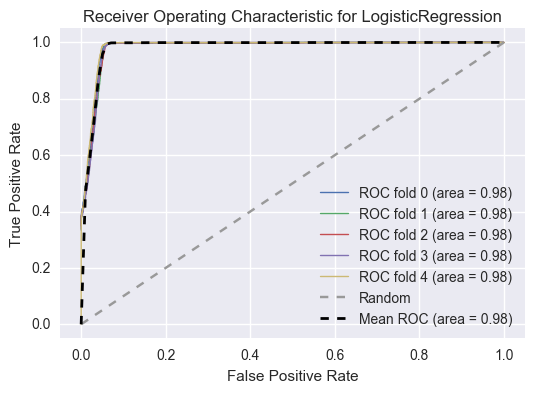

25.97477616251083
26.586529102589058
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,26.59,43.67,79.69,63.84,LogisticRegression,19.80,25.97,73.41


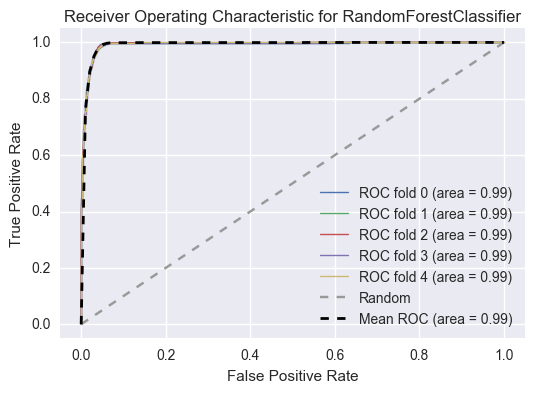

23.914508520265716
24.40140159626241
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,24.40,42.52,79.72,65.17,RandomForestClassifier,19.85,23.91,75.60


In [99]:
from IPython.display import display, HTML

def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for {}'.format(classifier.__class__.__name__))
    plt.legend(loc="lower right")
    plt.show()

LR = LogisticRegression(C=0.01, class_weight=penalty)
DT = DecisionTreeClassifier(random_state=1, class_weight=penalty)
RFR = RandomForestRegressor(n_estimators=100, random_state=1) #.fit(features,target)
#RFC = RandomForestClassifier(n_estimators=100, random_state=1, class_weight=penalty) #.fit(features,target)
RFC = RandomForestClassifier(n_estimators=100, bootstrap=True, min_samples_leaf=5, max_depth=20, 
                             max_features=10, class_weight=penalty)

plot_ROC_curve(LR, X_train.values, y_train.astype(int))
metrics, elapsed = run_classifier(clf=LR, X=X_train, y=y_train.astype(int), random=1)
display(metrics)
#plot_ROC_curve(DT, features.values, target.astype(int))
plot_ROC_curve(RFC, X_train.values, y_train.astype(int))
metrics, elapsed = run_classifier(clf=RFC, X=X_train, y=y_train.astype(int), random=1)
display(metrics)

In [179]:
RFC.predict_proba(X_train)[:,0]

array([ 0.79444012,  0.8972074 ,  0.96159346, ...,  0.82707258,
        0.81758918,  0.87632513])

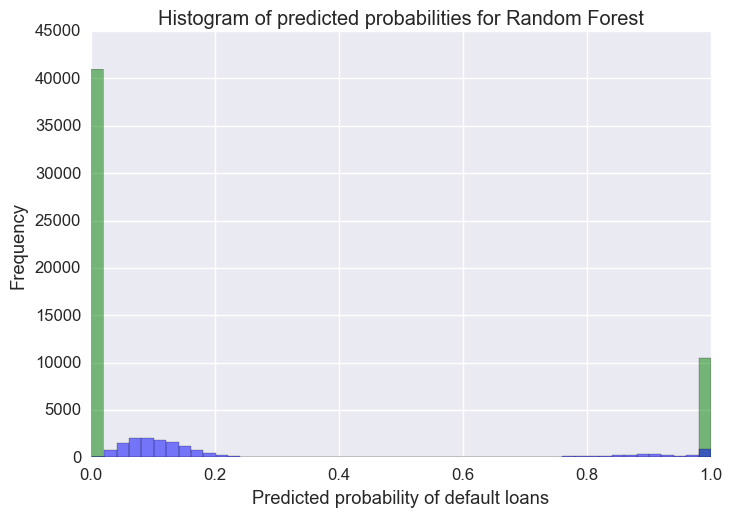

In [220]:
plt.hist(y_train, bins=50, alpha=0.5, color='g')
plt.hist(RFC.predict_proba(X_test)[:, 1], bins=50, alpha=0.5, color='b')

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities for Random Forest')
plt.xlabel('Predicted probability of default loans')
plt.ylabel('Frequency')

In [32]:
penalty
LR.__class__.__name__

'LogisticRegression'

Running a Prediction Pipeline

In [150]:
from IPython.display import display, HTML

penalty = { 0: 1,
            1: 8 }

LR = LogisticRegression(C=0.01, class_weight=penalty)
DT = DecisionTreeClassifier(random_state=1, class_weight=penalty)
#RFC = RandomForestClassifier(n_estimators=100, random_state=1, class_weight=penalty) #.fit(features,target)
RFC = RandomForestClassifier(n_estimators=100, bootstrap=True, min_samples_leaf=5, max_depth=20, 
                             max_features=10, class_weight=penalty)
ADA = AdaBoostClassifier(n_estimators=200, learning_rate=0.7)
svc = SVC(C=0.01, random_state=1, class_weight=None)

classifiers = [DT, LR, RFC]

results = pd.DataFrame()

for clf in classifiers:
    print ("Running Classifier {}".format(clf.__class__.__name__))
    metrics, elapsed = run_classifier(clf=clf, X=X_train, y=y_train.astype(int), penalty=penalty, random=1)
    results.append(metrics)
    display(metrics)

display(results)

Running Classifier DecisionTreeClassifier
19.919129681332436
20.29394588281098
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,20.29,39.85,79.75,50.73,DecisionTreeClassifier,19.88,19.92,79.71


Running Classifier LogisticRegression
25.647443920284974
26.221530075919798
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,26.22,43.50,79.70,48.05,LogisticRegression,19.82,25.65,73.78


Running Classifier RandomForestClassifier
23.644940791373834
24.15076893128285
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,24.15,42.35,79.72,48.99,RandomForestClassifier,19.84,23.64,75.85


""


Precision Recall (PR) Curves

In [89]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def PR_Curve(clf, X, y):
    print ("Calculate Aera Under Precision/Recall Curve for {}:".format(clf.__class__.__name__))
    clf.fit(X_train, y_train)
    precision, recall, thresholds = precision_recall_curve(y.astype(int), clf.predict_proba(X)[:,1])
    area = auc(recall, precision)
    print ("Area Under PR Curve(AP): %0.2f" % area)  #should be same as AP?

    print ('AP', average_precision_score(y_test, clf.predict_proba(X)[:,1], average='weighted'))
    print ('AP', average_precision_score(y_test, clf.predict_proba(X)[:,1], average='macro'))
    print ('AP', average_precision_score(y_test, clf.predict_proba(X)[:,1], average='micro'))
    print ('AP', average_precision_score(y_test, clf.predict_proba(X)[:,1], average='samples'))
    print ("")
    
PR_Curve(LR, X_test, y_test)
PR_Curve(DT, X_test, y_test)
PR_Curve(RFC, X_test, y_test)

Calculate Aera Under Precision/Recall Curve for LogisticRegression:
Area Under PR Curve(AP): 0.93
AP 0.934721162848
AP 0.934721162848
AP 0.934721162848
AP 0.934721162848

Calculate Aera Under Precision/Recall Curve for DecisionTreeClassifier:
Area Under PR Curve(AP): 0.94
AP 0.940451270474
AP 0.940451270474
AP 0.940451270474
AP 0.940451270474

Calculate Aera Under Precision/Recall Curve for RandomForestClassifier:
Area Under PR Curve(AP): 0.97
AP 0.974698779701
AP 0.974698779701
AP 0.974698779701
AP 0.974698779701



In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

SVM: Optimise parameters

In [93]:
from sklearn.metrics import classification_report

penalty = {
    0: 1,
    1: 11
}

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LR(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



TypeError: 'LogisticRegression' object is not callable

Feature Importance

(0.0, 0.4)

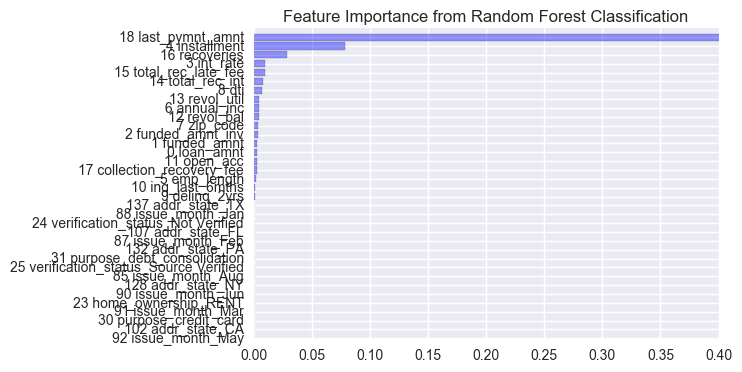

In [42]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

RF = RandomForestRegressor(n_estimators=100, random_state=1).fit(features,target)

feature_names = np.array([' '.join([str(b), a]) for a,b in zip(features.columns,range(len(features.columns)))])

importance = np.mean([tree.feature_importances_ for tree in RF.estimators_],axis=0)
std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importance)
range_ = range(len(importance))
plt.figure()
plt.title("Feature Importance from Random Forest Classification")

plt.barh(range_, importance[indices], color="b", xerr=None, alpha=0.4, align="center") # xerr=std[indices]

plt.yticks(range(len(importance)), feature_names[indices])
plt.ylim([110, len(importance)])
#plt.ylim([100, 135])
plt.xlim([0.0, 0.4])

*Benchmark*

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_


**III. Methodology**

*Data Preprocessing*

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


*Implementation*

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_



*Refinement*

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



Trying to balance the dataset to improve performance: Undersampling

In [120]:
from collections import Counter
from imblearn.under_sampling import NearMiss 

nm = NearMiss(random_state=1)
X_res, y_res = nm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 10510, 1: 10510})


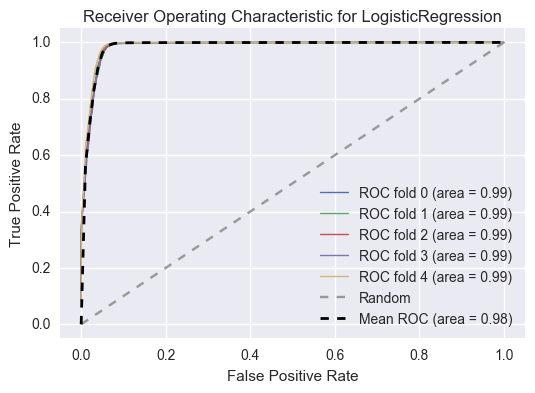

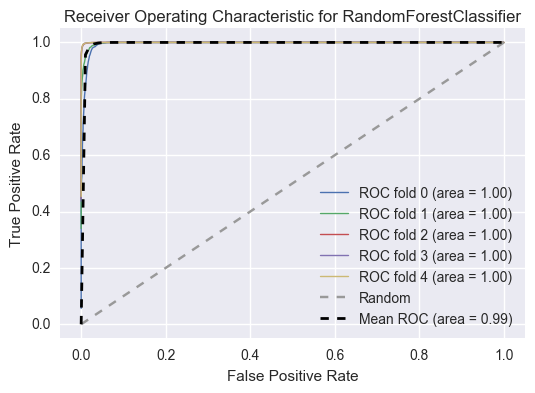

43.40852130325815
43.406060827740085
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,43.41,49.56,79.66,53.91,LogisticRegression,20.35,43.41,56.59


42.11958467597565
41.84056036138188
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,41.84,49.49,79.73,54.90,RandomForestClassifier,20.45,42.12,58.16


In [151]:
LR = LogisticRegression(C=0.01)
RFC = RandomForestClassifier(n_estimators=100, bootstrap=True)

plot_ROC_curve(LR, X_res, y_res)
plot_ROC_curve(RFC, X_res, y_res)

metrics, elapsed = run_classifier(clf=LR, X=X_res, y=y_res.astype(int), random=1)
display(metrics)

metrics, elapsed = run_classifier(clf=RFC, X=X_res, y=y_res.astype(int), random=1)
display(metrics)

Trying to balance the dataset to improve performance: Oversampling with SMOTE

Testing SMOTE algorithm

In [122]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 40973, 1: 40973})


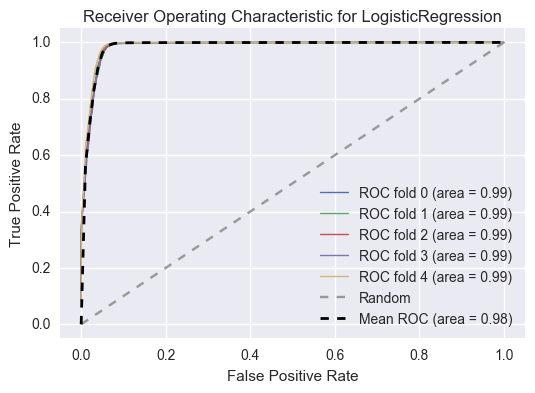

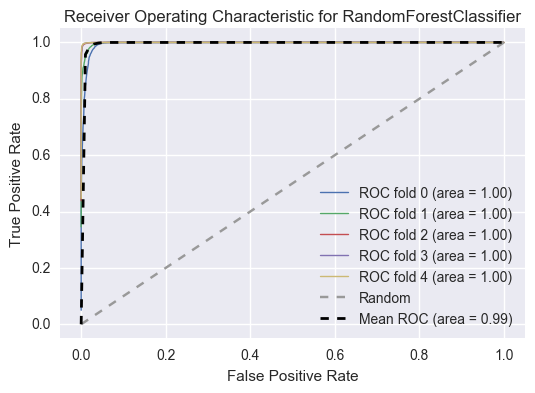

43.40852130325815
43.406060827740085
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,43.41,49.56,79.66,53.91,LogisticRegression,20.35,43.41,56.59


42.04081632653061
41.82044294884691
All Measurements:


,False Positive Rate,G-mean,Negative Predictive Value,accuracy,classifier,precision,sensitivity,specificity
values,41.82,49.46,79.72,54.90,RandomForestClassifier,20.43,42.04,58.18


In [152]:
LR = LogisticRegression(C=0.01)
RFC = RandomForestClassifier(n_estimators=100, bootstrap=True)

plot_ROC_curve(LR, X_res, y_res)
plot_ROC_curve(RFC, X_res, y_res)

metrics, elapsed = run_classifier(clf=LR, X=X_res, y=y_res.astype(int), random=1)
display(metrics)

metrics, elapsed = run_classifier(clf=RFC, X=X_res, y=y_res.astype(int), random=1)
display(metrics)

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_res, y_res = cc.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

LR = LogisticRegression(C=0.01)
RFC = RandomForestClassifier(n_estimators=100, bootstrap=True)

plot_ROC_curve(LR, X_res, y_res)
plot_ROC_curve(RFC, X_res, y_res)

** IV. Results **

*Model Evaluation and Validation*

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


*Justification*

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

**V. Conclusion**

Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_
